📊 Loading data...
✅ Data loaded successfully!

Creating overview dashboard...
✅ Saved: 01_network_overview.png

📊 Quick Stats:
   Total Users: 1290
   Total Interactions: 1426
   Super-Spreaders: 15
   Most Active Subreddit: memes
   Peak Hour: 18:00 UTC

✅ Part 1 Complete! Run part 2 next for network structure analysis.


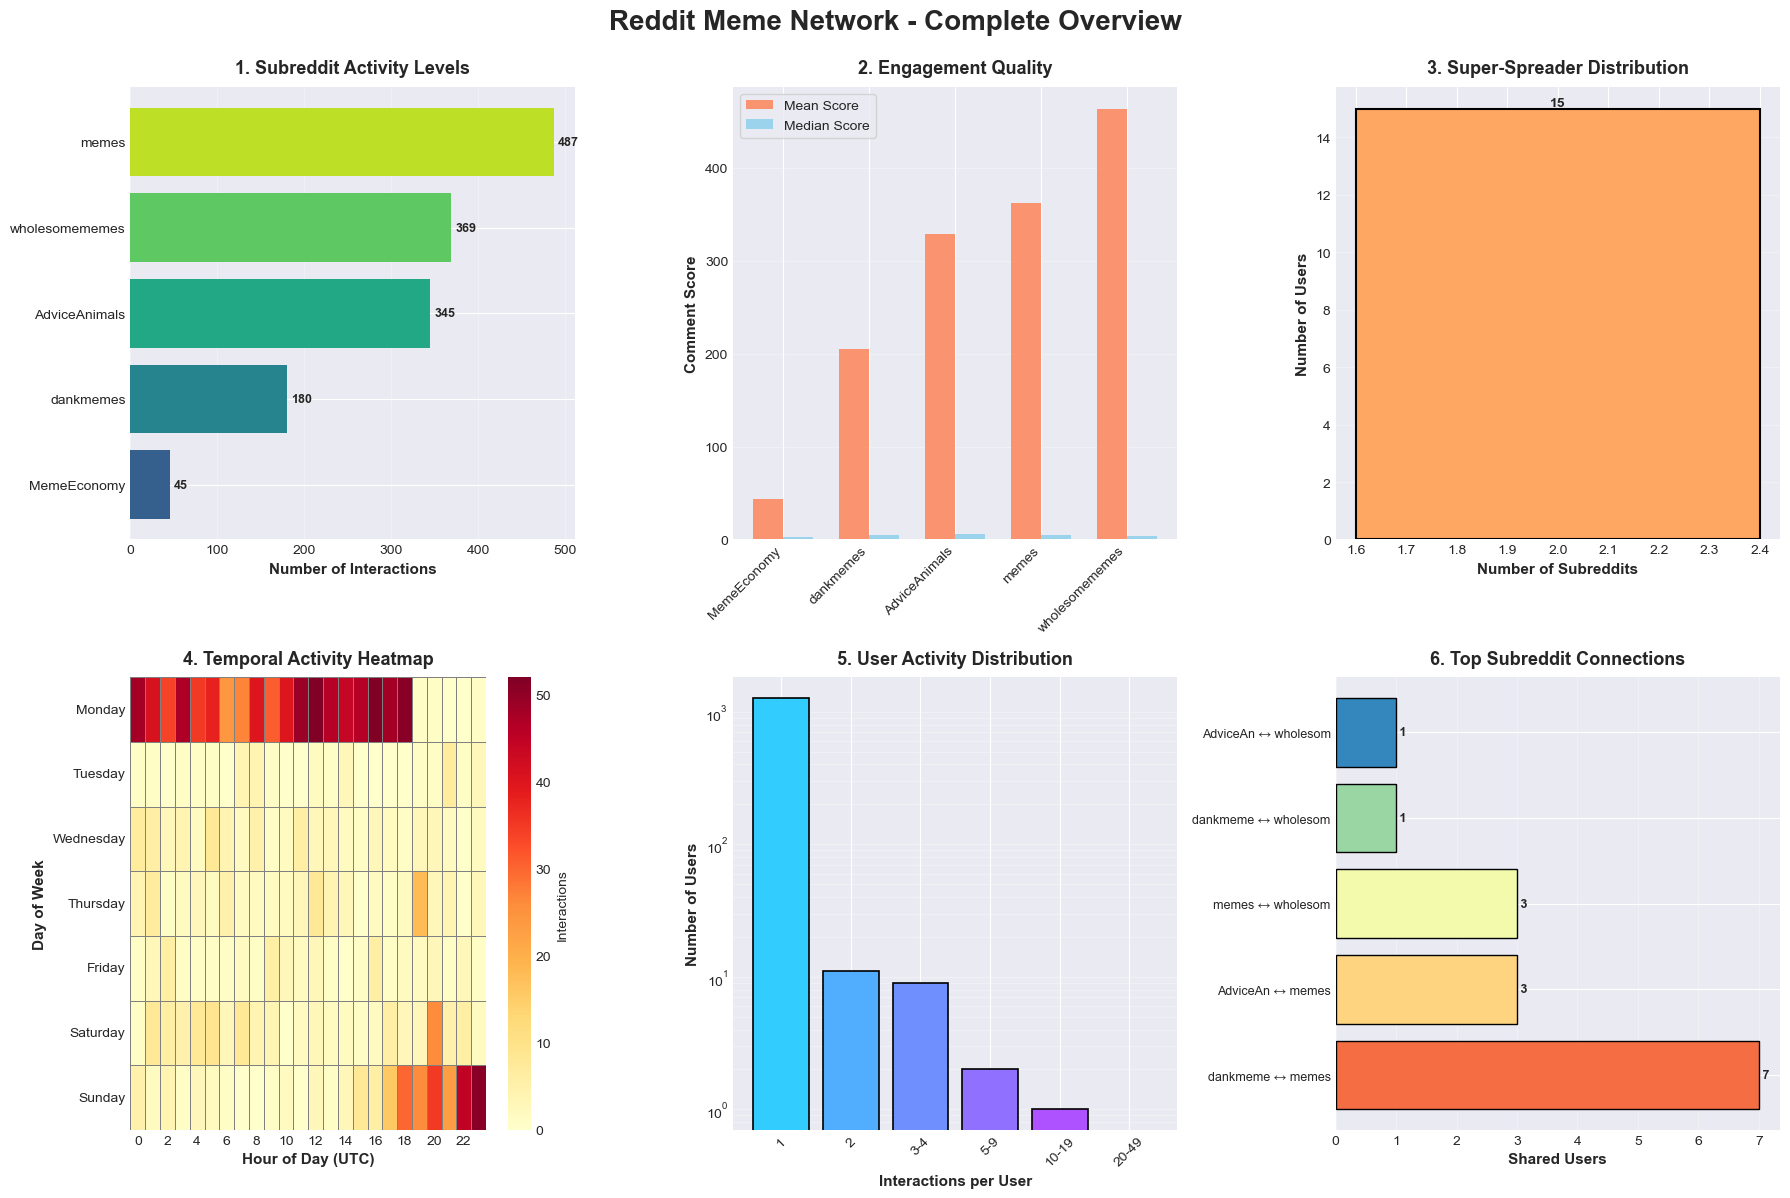

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

"""
PART 1: NETWORK OVERVIEW VISUALIZATIONS
---------------------------------------
Run this first to get the main overview dashboard
"""

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("📊 Loading data...")
df_detailed = pd.read_csv('reddit_interactions_detailed.csv')
df_super = pd.read_csv('super_spreaders.csv')

# Clean data
df_detailed = df_detailed.dropna(subset=['user'])
df_detailed = df_detailed[df_detailed['user'] != 'None']
df_detailed['user'] = df_detailed['user'].astype(str)
df_detailed['timestamp'] = pd.to_datetime(df_detailed['timestamp'])
df_detailed['hour'] = df_detailed['timestamp'].dt.hour
df_detailed['day'] = df_detailed['timestamp'].dt.day_name()

print("✅ Data loaded successfully!\n")

# ========================================
# FIGURE 1: NETWORK OVERVIEW (6 panels)
# ========================================
print("Creating overview dashboard...")
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Reddit Meme Network - Complete Overview', fontsize=20, fontweight='bold', y=0.995)

# Panel 1: Subreddit Activity
ax1 = plt.subplot(2, 3, 1)
subreddit_counts = df_detailed.groupby('target_subreddit').size().sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(subreddit_counts)))
bars = ax1.barh(subreddit_counts.index, subreddit_counts.values, color=colors)
ax1.set_xlabel('Number of Interactions', fontsize=11, fontweight='bold')
ax1.set_title('1. Subreddit Activity Levels', fontsize=13, fontweight='bold', pad=10)
ax1.grid(axis='x', alpha=0.3)
for bar in bars:
    width = bar.get_width()
    ax1.text(width + 5, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             ha='left', va='center', fontsize=9, fontweight='bold')

# Panel 2: Engagement Quality
ax2 = plt.subplot(2, 3, 2)
engagement = df_detailed.groupby('target_subreddit')['comment_score'].agg(['mean', 'median']).sort_values('mean')
x = np.arange(len(engagement))
width = 0.35
ax2.bar(x - width/2, engagement['mean'], width, label='Mean Score', color='coral', alpha=0.8)
ax2.bar(x + width/2, engagement['median'], width, label='Median Score', color='skyblue', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels([s.replace('r/', '') for s in engagement.index], rotation=45, ha='right')
ax2.set_ylabel('Comment Score', fontsize=11, fontweight='bold')
ax2.set_title('2. Engagement Quality', fontsize=13, fontweight='bold', pad=10)
ax2.legend(frameon=True, fancybox=True)
ax2.grid(axis='y', alpha=0.3)

# Panel 3: Super-Spreaders
ax3 = plt.subplot(2, 3, 3)
spreader_dist = df_super['subreddit_count'].value_counts().sort_index()
colors_spread = plt.cm.Oranges(np.linspace(0.4, 0.9, len(spreader_dist)))
bars3 = ax3.bar(spreader_dist.index, spreader_dist.values, color=colors_spread, 
                edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Number of Subreddits', fontsize=11, fontweight='bold')
ax3.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax3.set_title('3. Super-Spreader Distribution', fontsize=13, fontweight='bold', pad=10)
ax3.grid(axis='y', alpha=0.3)
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Panel 4: Temporal Heatmap
ax4 = plt.subplot(2, 3, 4)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = df_detailed.groupby(['day', 'hour']).size().unstack(fill_value=0)
heatmap_data = heatmap_data.reindex(day_order)
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Interactions'}, 
            linewidths=0.5, linecolor='gray')
ax4.set_xlabel('Hour of Day (UTC)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Day of Week', fontsize=11, fontweight='bold')
ax4.set_title('4. Temporal Activity Heatmap', fontsize=13, fontweight='bold', pad=10)

# Panel 5: User Activity Distribution
ax5 = plt.subplot(2, 3, 5)
user_activity = df_detailed.groupby('user').size()
max_activity = max(user_activity)

# Create proper bins
bins = [1, 2, 3, 5, 10, 20, max(50, max_activity + 1)]
bins = sorted(set(bins))

hist_data = pd.cut(user_activity, bins=bins, include_lowest=True).value_counts().sort_index()
colors5 = plt.cm.cool(np.linspace(0.2, 0.8, len(hist_data)))
bars5 = ax5.bar(range(len(hist_data)), hist_data.values, color=colors5, 
                edgecolor='black', linewidth=1.2)

# Dynamic labels
labels = []
for i in range(len(bins)-1):
    if bins[i+1] == bins[i] + 1:
        labels.append(f'{int(bins[i])}')
    else:
        labels.append(f'{int(bins[i])}-{int(bins[i+1]-1)}')

ax5.set_xticks(range(len(hist_data)))
ax5.set_xticklabels(labels, rotation=45)
ax5.set_xlabel('Interactions per User', fontsize=11, fontweight='bold')
ax5.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax5.set_title('5. User Activity Distribution', fontsize=13, fontweight='bold', pad=10)
ax5.set_yscale('log')
ax5.grid(axis='y', alpha=0.3, which='both')

# Panel 6: Cross-Subreddit Connections
ax6 = plt.subplot(2, 3, 6)
multi_users = df_detailed.groupby('user')['target_subreddit'].apply(list).reset_index()
multi_users = multi_users[multi_users['target_subreddit'].apply(len) > 1]

transitions = {}
for subs in multi_users['target_subreddit']:
    subs_unique = list(set(subs))
    for i in range(len(subs_unique)):
        for j in range(i+1, len(subs_unique)):
            pair = tuple(sorted([subs_unique[i], subs_unique[j]]))
            transitions[pair] = transitions.get(pair, 0) + 1

top_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)[:10]
labels = [f"{s1[:8]} ↔ {s2[:8]}" for (s1, s2), _ in top_transitions]
values = [count for _, count in top_transitions]

colors6 = plt.cm.Spectral(np.linspace(0.2, 0.9, len(values)))
bars6 = ax6.barh(range(len(values)), values, color=colors6, edgecolor='black', linewidth=1)
ax6.set_yticks(range(len(values)))
ax6.set_yticklabels(labels, fontsize=9)
ax6.set_xlabel('Shared Users', fontsize=11, fontweight='bold')
ax6.set_title('6. Top Subreddit Connections', fontsize=13, fontweight='bold', pad=10)
ax6.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars6, values)):
    ax6.text(val, i, f' {val}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
# plt.savefig('01_network_overview.png', dpi=300, bbox_inches='tight')
# print("✅ Saved: 01_network_overview.png")

# ========================================
# SUMMARY STATS
# ========================================
print("\n📊 Quick Stats:")
print(f"   Total Users: {df_detailed['user'].nunique()}")
print(f"   Total Interactions: {len(df_detailed)}")
print(f"   Super-Spreaders: {len(df_super)}")
print(f"   Most Active Subreddit: {subreddit_counts.idxmax()}")
print(f"   Peak Hour: {df_detailed.groupby('hour').size().idxmax()}:00 UTC")

print("\n✅ Part 1 Complete! Run part 2 next for network structure analysis.")